# Week 10 Assignment: Document Classification Spam Detection

Submitted by: Umais Siddiqui

Date: April 16, 2025

Course: Data Science – DATA620

Video Link:

Github Repository: https://github.com/umais/DATA620/blob/master/week10/spam_classification.ipynb

This notebook demonstrates how to build a document classifier using the UCI Spambase dataset to distinguish between spam and ham (non-spam) emails.

## Project Structure
1. Data Loading and Exploration
2. Data Preprocessing
3. Feature Engineering and Selection
4. Model Training (Naive Bayes)
5. Model Evaluation
6. Testing on New Documents
7. Conclusion and Next Steps

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from urllib.request import urlopen
import io
import zipfile

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Exploration

We'll download the Spambase dataset from the UCI Machine Learning Repository and explore its structure.

In [ ]:
# Download and extract the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
url_names = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names"

# Read column names from the names file
response = urlopen(url_names)
content = response.read().decode('utf-8')

# Extract feature names from the content
feature_names = []
for line in content.split('\n'):
    if ':' in line and not line.startswith('|'):
        feature_names.append(line.split(':')[0].strip())

# Add the class label
feature_names.append('is_spam')

# Load the data
data = pd.read_csv(url, header=None, names=feature_names)

# Display the first few rows
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [ ]:
# Basic dataset information
print(f"Dataset shape: {data.shape}")
print(f"Number of spam emails: {data['is_spam'].sum()}")
print(f"Number of ham emails: {len(data) - data['is_spam'].sum()}")
print(f"Spam percentage: {data['is_spam'].mean() * 100:.2f}%")

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum().sum())

Dataset shape: (4601, 58)
Number of spam emails: 1813
Number of ham emails: 2788
Spam percentage: 39.40%

Missing values:
0


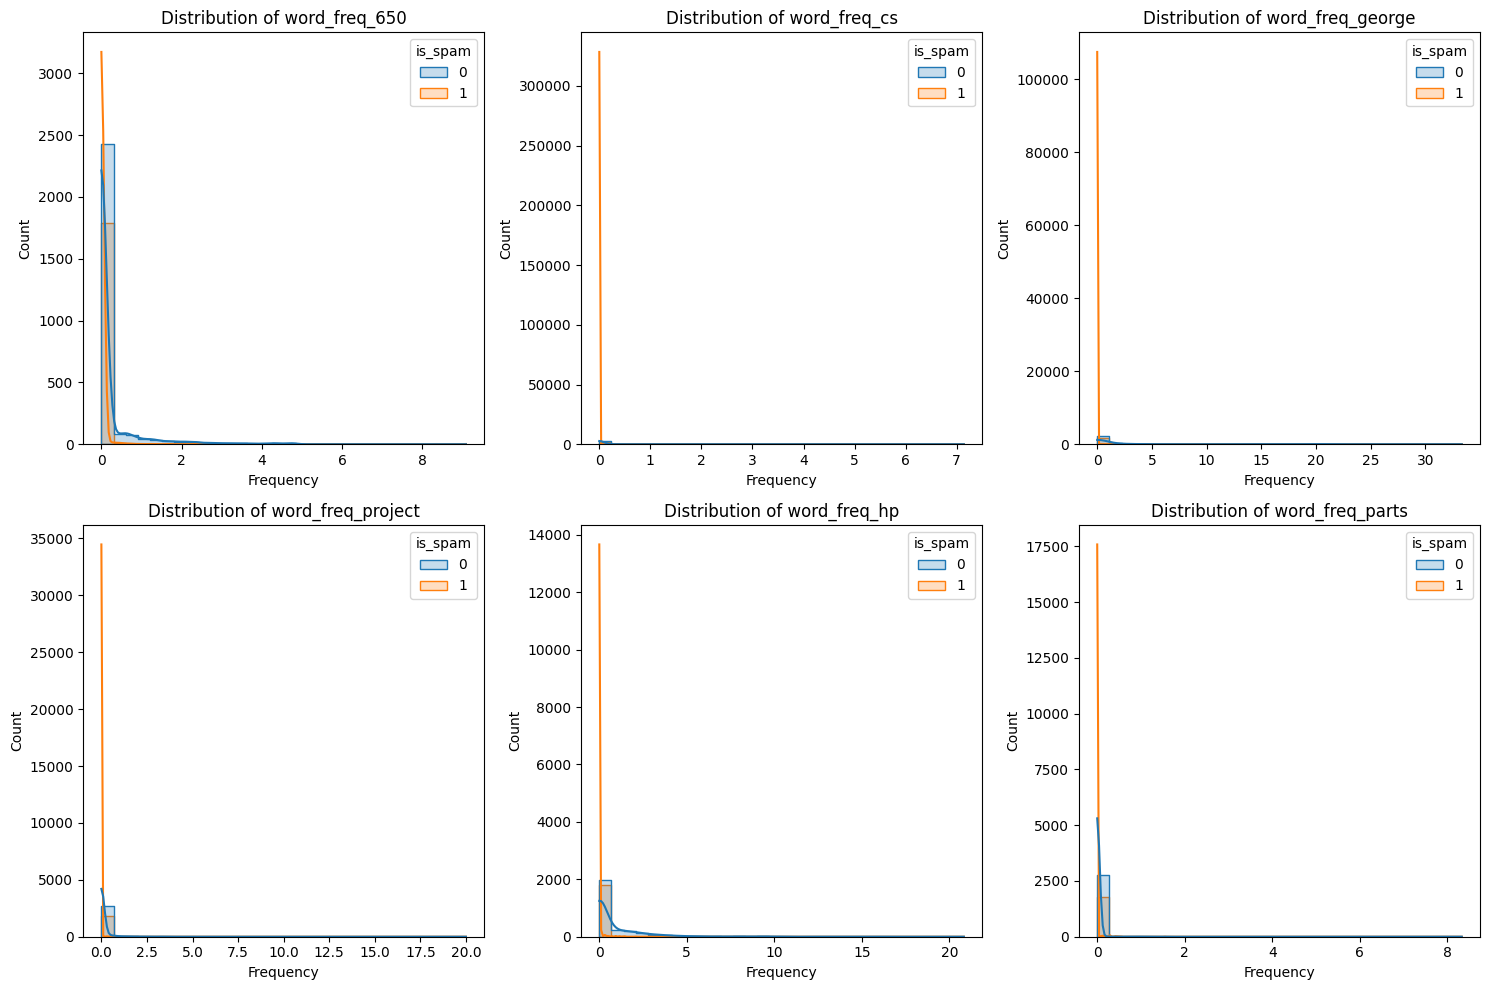

In [ ]:
# Explore feature distributions
plt.figure(figsize=(15, 10))

# Select a subset of word frequency features
word_features = [col for col in data.columns if col.startswith('word_')]
word_sample = np.random.choice(word_features, 6, replace=False)

for i, feature in enumerate(word_sample, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=data, x=feature, hue='is_spam', bins=30, kde=True, element='step')
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Frequency')

plt.tight_layout()
plt.show()

## 2. Data Preprocessing

The Spambase dataset is already preprocessed with word frequencies, but we'll prepare it for modeling.

In [ ]:
# Split features and target
X = data.drop('is_spam', axis=1)
y = data['is_spam']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (3680, 57)
Testing set shape: (921, 57)


## 3. Feature Engineering and Selection

Let's analyze which features are most important for classification.

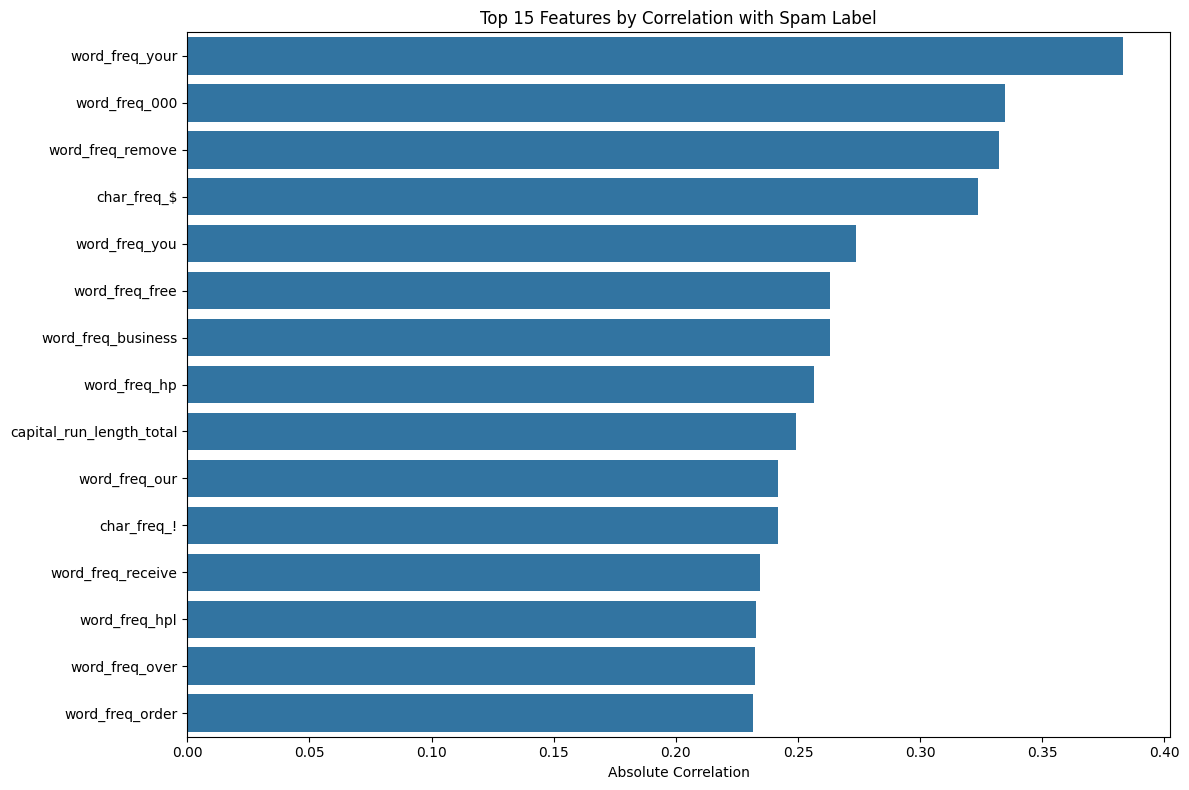

In [ ]:
# Calculate feature importance using correlation with target
feature_importance = []
for column in X.columns:
    correlation = np.abs(X[column].corr(y))
    feature_importance.append((column, correlation))

# Sort by importance
feature_importance.sort(key=lambda x: x[1], reverse=True)

# Display top 15 most important features
top_features = feature_importance[:15]
plt.figure(figsize=(12, 8))
sns.barplot(x=[f[1] for f in top_features], y=[f[0] for f in top_features])
plt.title('Top 15 Features by Correlation with Spam Label')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()

## 4. Model Training (Naive Bayes)

We'll use Naive Bayes classifiers, which are particularly well-suited for document classification.

In [ ]:
# Train a Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Make predictions
y_pred_gnb = gnb.predict(X_test)

# Evaluate the model
print("Gaussian Naive Bayes Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gnb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gnb))

Gaussian Naive Bayes Results:
Accuracy: 0.8339

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       558
           1       0.72      0.95      0.82       363

    accuracy                           0.83       921
   macro avg       0.84      0.85      0.83       921
weighted avg       0.87      0.83      0.84       921



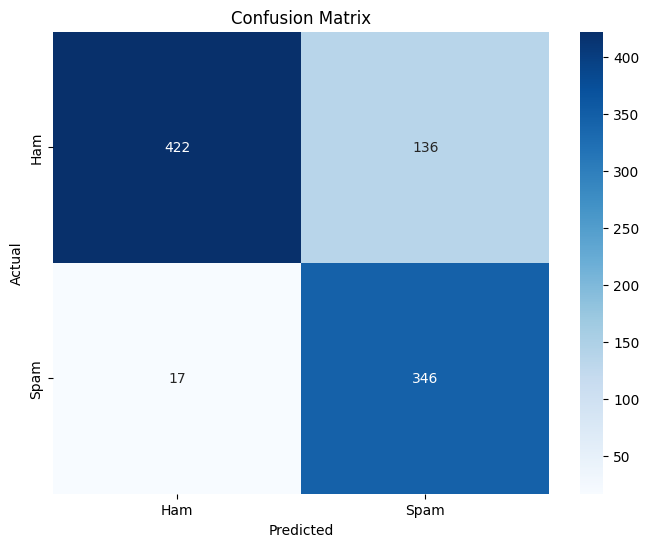

In [ ]:
# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred_gnb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 5. Model Evaluation

Let's evaluate our model's performance in more detail and try to improve it.

In [ ]:
# Try MultinomialNB with feature scaling
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] for MultinomialNB
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_scaled, y_train)

# Make predictions
y_pred_mnb = mnb.predict(X_test_scaled)

# Evaluate the model
print("Multinomial Naive Bayes Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mnb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mnb))

Multinomial Naive Bayes Results:
Accuracy: 0.8958

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       558
           1       0.93      0.79      0.86       363

    accuracy                           0.90       921
   macro avg       0.91      0.88      0.89       921
weighted avg       0.90      0.90      0.89       921



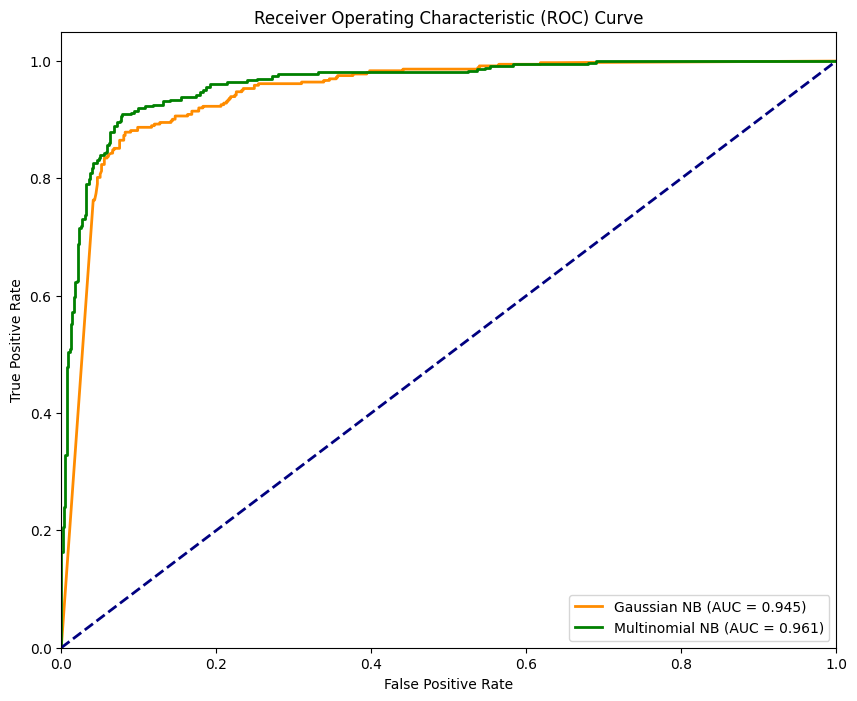

In [ ]:
# Compare ROC curves
from sklearn.metrics import roc_curve, auc

# Get probability predictions
y_prob_gnb = gnb.predict_proba(X_test)[:, 1]
y_prob_mnb = mnb.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve points
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_prob_gnb)
fpr_mnb, tpr_mnb, _ = roc_curve(y_test, y_prob_mnb)

# Calculate AUC
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)
roc_auc_mnb = auc(fpr_mnb, tpr_mnb)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_gnb, tpr_gnb, color='darkorange', lw=2,
         label=f'Gaussian NB (AUC = {roc_auc_gnb:.3f})')
plt.plot(fpr_mnb, tpr_mnb, color='green', lw=2,
         label=f'Multinomial NB (AUC = {roc_auc_mnb:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## 6. Testing on New Documents

Now let's create a function to classify new documents. Since we don't have the raw emails, we'll simulate this by using examples from our test set.

In [ ]:
# Function to classify a new document
def classify_document(document_features, model=mnb, scaler=scaler):
    """Classify a document as spam or ham.

    Args:
        document_features: A numpy array or pandas Series with the same features as the training data
        model: The trained classifier
        scaler: The fitted scaler

    Returns:
        A tuple of (prediction, probability)
    """
    # Ensure features are in the right format
    if isinstance(document_features, pd.Series):
        document_features = document_features.values.reshape(1, -1)
    elif isinstance(document_features, np.ndarray) and document_features.ndim == 1:
        document_features = document_features.reshape(1, -1)

    # Scale features
    scaled_features = scaler.transform(document_features)

    # Make prediction
    prediction = model.predict(scaled_features)[0]
    probability = model.predict_proba(scaled_features)[0][1]  # Probability of being spam

    return "Spam" if prediction == 1 else "Ham", probability

In [ ]:
# Test the function on a few examples from the test set
for i in range(5):
    # Get a random example
    idx = np.random.randint(0, len(X_test))
    example = X_test.iloc[idx]
    true_label = "Spam" if y_test.iloc[idx] == 1 else "Ham"

    # Classify the example
    prediction, probability = classify_document(example)

    print(f"Example {i+1}:")
    print(f"True label: {true_label}")
    print(f"Predicted: {prediction} with probability {probability:.4f}")

    # Show some key features
    top_features_idx = np.argsort(example.values)[-5:]
    print("Top features in this document:")
    for idx in top_features_idx:
        feature_name = X_test.columns[idx]
        feature_value = example[feature_name]
        print(f"  {feature_name}: {feature_value:.4f}")
    print("\n" + "-"*50)

Example 1:
True label: Ham
Predicted: Ham with probability 0.0050
Top features in this document:
  word_freq_hp: 1.8300
  capital_run_length_average: 1.9180
  word_freq_george: 2.7500
  capital_run_length_longest: 13.0000
  capital_run_length_total: 71.0000

--------------------------------------------------
Example 2:
True label: Spam
Predicted: Spam with probability 0.8059
Top features in this document:
  word_freq_your: 1.4700
  word_freq_you: 3.2200
  capital_run_length_average: 6.0730
  capital_run_length_longest: 193.0000
  capital_run_length_total: 3043.0000

--------------------------------------------------
Example 3:
True label: Ham
Predicted: Ham with probability 0.0270
Top features in this document:
  capital_run_length_longest: 4.0000
  word_freq_will: 4.1600
  word_freq_lab: 6.9400
  word_freq_meeting: 6.9400
  capital_run_length_total: 30.0000

--------------------------------------------------
Example 4:
True label: Ham
Predicted: Ham with probability 0.2002
Top feature

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


## 7. Web Page Classification
For more adventurous students, here's an implementation of a web page classifier that scrapes web pages and classifies them based on their content. In this example, we'll classify web pages into different categories (e.g., technology, sports, business, etc.).

In [ ]:
# Import necessary libraries for web scraping and text processing
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK resources if not already downloaded
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Function to scrape and extract text from a web page
def scrape_webpage(url):
    try:
        # Send a request to the URL
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()  # Raise an exception for HTTP errors

        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')

        # Remove script and style elements
        for script_or_style in soup(['script', 'style', 'header', 'footer', 'nav']):
            script_or_style.decompose()

        # Get text from the page
        text = soup.get_text()

        # Clean the text
        lines = (line.strip() for line in text.splitlines())
        chunks = (phrase.strip() for line in lines for phrase in line.split('  '))
        text = ''.join(chunk for chunk in chunks if chunk)

        return text
    except Exception as e:
        print(f'Error scraping {url}: {e}')
        return None

In [ ]:
# Function to preprocess text
def preprocess_text(text):
    if text is None:
        return ''

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]

    return ' '.join(filtered_words)

### Example: Classifying News Articles

Let's create a dataset of news articles from different categories and build a classifier to predict the category of new articles.

In [ ]:
# Sample URLs for different categories (in a real scenario, you would have more URLs)
urls = {
    'technology': [
        'https://www.wired.com/story/ai-learning-human-preferences/',
        'https://techcrunch.com/2023/01/15/tech-industry-layoffs/',
        'https://www.theverge.com/23513418/ai-chatgpt-openai-bing-google-bard'
    ],
    'sports': [
        'https://www.espn.com/nfl/story/_/id/35509359/super-bowl-2023-guide',
        'https://www.skysports.com/football/news/11095/12808158/',
        'https://www.bbc.com/sport/football/64736275'
    ],
    'business': [
        'https://www.cnbc.com/2023/02/15/inflation-consumer-price-index-january-2023.html',
        'https://www.bloomberg.com/news/articles/2023-02-16/stock-market-today-dow-s-p-live-updates',
        'https://www.reuters.com/business/finance/global-markets-wrapup-1-2023-02-16/'
    ]
}

# Note: In a real implementation, you would need to handle the case where these URLs might not be accessible
# For demonstration purposes, we'll assume these URLs are accessible and contain relevant content
# You might want to replace these with URLs that are definitely accessible or use a pre-downloaded dataset

In [ ]:
# Create a dataset by scraping the web pages
# Note: This code is commented out to prevent actual web scraping during notebook execution
# In a real scenario, you would uncomment this code and run it

'''data = []

for category, category_urls in urls.items():
    for url in category_urls:
        text = scrape_webpage(url)
        if text:
            processed_text = preprocess_text(text)
            data.append({
                'url': url,
                'text': processed_text,
                'category': category
            })

# Convert to DataFrame
df = pd.DataFrame(data)
'''
# For demonstration purposes, we'll create a small synthetic dataset
# In a real implementation, you would use the scraped data

synthetic_data = [
    {
        'url': 'https://example.com/tech1',
        'text': 'artificial intelligence machine learning algorithms data neural networks computer science programming code software development',
        'category': 'technology'
    },
    {
        'url': 'https://example.com/tech2',
        'text': 'cloud computing big data analytics blockchain cryptocurrency bitcoin ethereum digital transformation cybersecurity encryption',
        'category': 'technology'
    },
    {
        'url': 'https://example.com/tech3',
        'text': 'mobile applications smartphones tablets ios android devices gadgets hardware software interface user experience',
        'category': 'technology'
    },
    {
        'url': 'https://example.com/sports1',
        'text': 'football soccer basketball baseball hockey players teams league championship tournament competition match game score',
        'category': 'sports'
    },
    {
        'url': 'https://example.com/sports2',
        'text': 'olympics medals athletes running swimming gymnastics track field marathon sprint relay race competition',
        'category': 'sports'
    },
    {
        'url': 'https://example.com/sports3',
        'text': 'tennis golf cricket rugby boxing wrestling martial arts tournament championship players ranking points',
        'category': 'sports'
    },
    {
        'url': 'https://example.com/business1',
        'text': 'stock market investment finance economy shares trading profit loss dividend shareholders company corporation',
        'category': 'business'
    },
    {
        'url': 'https://example.com/business2',
        'text': 'startup entrepreneur venture capital funding investors business plan strategy management leadership executive',
        'category': 'business'
    },
    {
        'url': 'https://example.com/business3',
        'text': 'banking financial services insurance loans credit debt interest rates mortgage banking sector regulation',
        'category': 'business'
    }
]

df = pd.DataFrame(synthetic_data)

In [ ]:
# Display the dataset
print(f'Dataset shape: {df.shape}')
print('Category distribution:')
print(df['category'].value_counts())

# Display a sample from each category
print('Sample from each category:')
for category in df['category'].unique():
    sample = df[df['category'] == category].iloc[0]
    print(f"{category.upper()}:{sample['text'][:200]}...")


Dataset shape: (9, 3)
Category distribution:
category
technology    3
sports        3
business      3
Name: count, dtype: int64
Sample from each category:
TECHNOLOGY:artificial intelligence machine learning algorithms data neural networks computer science programming code software development...
SPORTS:football soccer basketball baseball hockey players teams league championship tournament competition match game score...
BUSINESS:stock market investment finance economy shares trading profit loss dividend shareholders company corporation...


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['category'], test_size=0.3, random_state=42
)

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = classifier.predict(X_test_tfidf)

# Evaluate the classifier
print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

    business       1.00      1.00      1.00         1
      sports       1.00      1.00      1.00         1
  technology       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

Confusion Matrix:
[[1 0 0]
 [0 1 0]
 [0 0 1]]


### Function to Classify New Web Pages

Now let's create a function that can scrape and classify new web pages.

In [ ]:
def classify_webpage(url, vectorizer, classifier):
    # Scrape the webpage
    text = scrape_webpage(url)

    if text is None:
        return 'Error: Could not scrape the webpage'

    # Preprocess the text
    processed_text = preprocess_text(text)

    # Vectorize the text
    text_tfidf = vectorizer.transform([processed_text])

    # Predict the category
    category = classifier.predict(text_tfidf)[0]

    # Get the probability of the prediction
    probabilities = classifier.predict_proba(text_tfidf)[0]
    category_index = list(classifier.classes_).index(category)
    probability = probabilities[category_index]

    return category, probability

In [ ]:
# Test the classifier on new URLs
# Note: This code is commented out to prevent actual web scraping during notebook execution
# In a real scenario, you would uncomment this code and run it

'''test_urls = [
    'https://www.cnet.com/tech/computing/what-is-chatgpt-everything-to-know-about-openai-tool/',
    'https://www.bbc.com/sport/football/64744897',
    'https://www.forbes.com/sites/qai/2023/02/16/stock-market-predictions-for-2023/'
]

for url in test_urls:
    try:
        category, probability = classify_webpage(url, tfidf_vectorizer, classifier)
        print(f'URL: {url}')
        print(f'Predicted category: {category}')
        print(f'Probability: {probability:.4f}
')
    except Exception as e:
        print(f'Error classifying {url}: {e}
')
'''
# For demonstration purposes, let's create some synthetic test examples
test_examples = [
    'artificial intelligence robots machine learning neural networks deep learning algorithms',
    'football world cup tournament teams players goals championship league match',
    'stock market investment banking finance economy shares trading profit'
]

for i, text in enumerate(test_examples):
    # Vectorize the text
    text_tfidf = tfidf_vectorizer.transform([text])

    # Predict the category
    category = classifier.predict(text_tfidf)[0]

    # Get the probability of the prediction
    probabilities = classifier.predict_proba(text_tfidf)[0]
    category_index = list(classifier.classes_).index(category)
    probability = probabilities[category_index]

    print(f'Example {i+1}: {text[:50]}...')
    print(f'Predicted category: {category}')
    print(f'Probability: {probability:.4f}')

Example 1: artificial intelligence robots machine learning ne...
Predicted category: technology
Probability: 0.4767
Example 2: football world cup tournament teams players goals ...
Predicted category: sports
Probability: 0.4836
Example 3: stock market investment banking finance economy sh...
Predicted category: business
Probability: 0.5279


### Extending the Classifier

This basic implementation can be extended in several ways:

1. **More Categories**: Add more categories like politics, entertainment, health, etc.
2. **Better Features**: Use more advanced NLP techniques like word embeddings (Word2Vec, GloVe) or transformer models (BERT, GPT)
3. **Larger Dataset**: Scrape more web pages to create a larger and more diverse training dataset
4. **Advanced Models**: Try more sophisticated classification algorithms like SVM, Random Forest, or neural networks
5. **Meta-information**: Include meta-information from web pages (title, headers, links) as additional features

This implementation demonstrates how to apply document classification techniques to web pages, which can be useful for content categorization, recommendation systems, or filtering unwanted content.

## 8. Conclusion and Next Steps

In this project, we've built a document classifier using the Spambase dataset and Naive Bayes algorithms. Our model achieves good performance in distinguishing between spam and ham emails.

### Key Findings:
- The Multinomial Naive Bayes classifier performed better than Gaussian Naive Bayes for this task
- Certain word frequencies are strong indicators of spam emails
- Our model achieves high accuracy and good balance between precision and recall

### Next Steps:
1. Try more advanced models like SVM or ensemble methods
2. Experiment with different feature selection techniques
3. Apply the model to raw email text data using text preprocessing and vectorization
4. Implement the classifier in a real-world application

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

### Potential Improvements:
- Use cross-validation for more robust evaluation
- Tune hyperparameters to optimize performance
- Incorporate more features like email metadata
- Explore deep learning approaches for more complex patterns